In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Create Masks

In [2]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt


import sys
sys.path.append('../')
from config import raw_data_dir

from rasterio.plot import show

%matplotlib inline

# Test dir
img_dir = '../data/interim/images/2017-01-01/'

## Read Shapefile

In [3]:
train_fp = os.path.join(raw_data_dir,'train/train.shp')
train_df = gpd.read_file(train_fp)

# Drop NaNs
train_df = train_df.loc[~train_df.geometry.isna()]
train_df.reset_index(drop=True, inplace=True)

# Convert shapefile to coordinate system of raster
train_df = train_df.to_crs({'init': 'epsg:32734'})

train_df.head()

,Field_Id,Area,Subregion,Crop_Id_Ne,geometry
0,1,0.915905,3,8,"POLYGON ((613924.3324000851 6793991.295069702,..."
1,2,2.064410,3,6,"POLYGON ((614404.0717397591 6794020.579634549,..."
2,3,1.080300,3,8,"POLYGON ((614320.2146632321 6793964.242091182,..."
3,4,1.316190,3,8,"POLYGON ((614560.5326844405 6794002.249461887,..."
4,7,5.529220,3,8,"POLYGON ((614596.6564746551 6794269.865436315,..."


In [4]:
train_df.shape

(2494, 5)

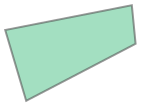

In [5]:
train_df.loc[0].geometry

## Get Polygon Masks From Raster

In [6]:
!ls $img_dir

B01_JEP.jp2 B03_JFP.jp2 B06_JEP.jp2 B08_JFP.jp2 B11_JEP.jp2 B8A_JFP.jp2
B01_JFP.jp2 B04_JEP.jp2 B06_JFP.jp2 B09_JEP.jp2 B11_JFP.jp2 TCI_JEP.jp2
B02_JEP.jp2 B04_JFP.jp2 B07_JEP.jp2 B09_JFP.jp2 B12_JEP.jp2 TCI_JFP.jp2
B02_JFP.jp2 B05_JEP.jp2 B07_JFP.jp2 B10_JEP.jp2 B12_JFP.jp2
B03_JEP.jp2 B05_JFP.jp2 B08_JEP.jp2 B10_JFP.jp2 B8A_JEP.jp2


### (OLD MASKING METHOD): Mask out a farm from the raster


**Raster**: The entire image containing all the farms

**Mask**: A shape defined as a polygon of points

In [7]:
import os
import rasterio
from rasterio.plot import show
from glob import glob

from rasterio import mask

def get_mask(shape, raster):
    if shape is None:
        return None
    try:
        mask_img, mask_transform = mask.mask(raster, [shape], crop=True)
    except ValueError:
        return None

    if mask_img.ndim == 3:
        # remove the first dimension
        return mask_img[0, :, :]
    elif mask_img.ndim == 2:
        return mask_img
    else:
        raise ValueError('Mask has unexpected shape: {}'.format(mask_img.shape))

**Crop out the masks and remove the missing ones**

In [8]:
fp = os.path.join(img_dir,'B04_JFP.jp2')

with rasterio.open(fp) as raster:
    masks = [get_mask(g, raster) for g in train_df.geometry]
    nan_idxs = [i for i,m in enumerate(masks) if m is None]

# Remove the farms that did not fit on this raster
masks = list(np.delete(np.array(masks), nan_idxs))
train_df.drop(nan_idxs, axis=0, inplace=True)

In [9]:
len(masks) == len(train_df)

True

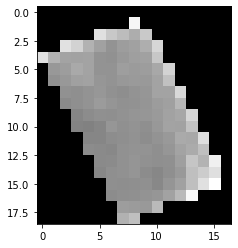

In [10]:
plt.imshow(masks[1], cmap='gray')

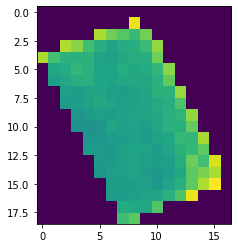

In [11]:
with rasterio.open(fp) as raster:
    plt.imshow(get_mask(train_df.iloc[1].geometry, raster))

### Visualize shape distributions

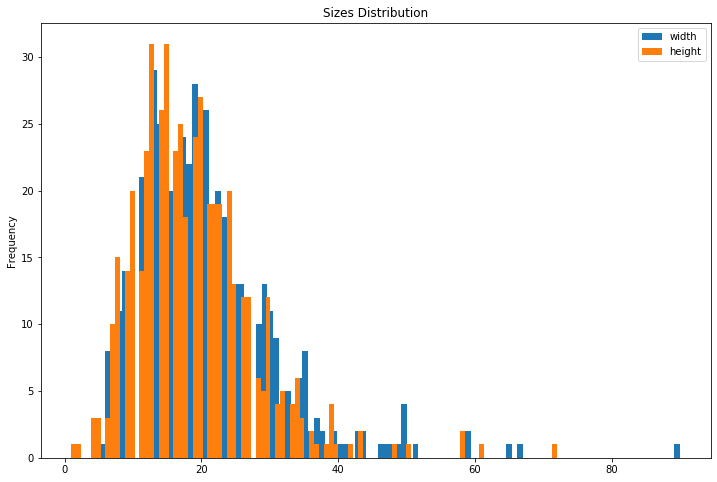

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter

shapes = [x.shape for x in masks]

widths = [x[0] for x in shapes]
heights = [x[1] for x in shapes]

w_plot = pd.Series(widths).plot.hist(bins=100, title='Sizes Distribution', label='width', figsize=(12,8))
h_plot = pd.Series(heights).plot.hist(bins=100, title='Sizes Distribution', label='height', figsize=(12,8))
plt.legend()
display(w_plot)
display(h_plot)

## New masking

For a given farm shape, get the data _around_ that farm in a fixed bounding box determined by the raster resolution. 

For example, at 10m resolution use 90x90.

### Pick a farm to prototype with

In [13]:
for i,s in enumerate(shapes):
    a,b = s
    if a==b and a >= 30:
        idx = i
        print(idx, s)
        break

14 (33, 33)


### Do the masking

1. Get the chosen shape and open the raster
2. Get the boolean mask as well as the bounding "window" of the shape on the raster
3. Convert the boolean mask to integer 
4. Read the image data from the raster, given the bounding window
5. Show the image containing the farm and the boolean mask together

bb_shape =  (33, 33)


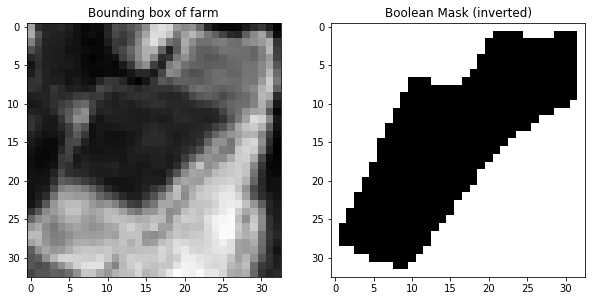

In [14]:
raster = rasterio.open(fp)

shape = train_df.geometry.iloc[idx]

# Get the boolean mask and window of shape
bool_mask, transform, bb_window = rasterio.mask.raster_geometry_mask(raster, [shape], crop=True)

# Turn mask into int array with 1 at farm pixels
int_mask = np.bitwise_not(bool_mask).astype(int)

# Get the shape of the bounding box window
bb_shape = (bb_window.width, bb_window.height)

print('bb_shape = ',bb_shape)

# Show original farm image
img = raster.read(window=bb_window, masked=True)


f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,10))
ax0.imshow(img[0], cmap='gray')
ax0.set_title('Bounding box of farm')
ax1.imshow(bool_mask, cmap='gray')
ax1.set_title("Boolean Mask (inverted)")
plt.show()

### Now get the farm in the center of a fixed size image

We will get the image data of the farm as above, but now also get surrounding image data up to a size of `MAX_DIMS`. 

`MAX_DIMS` is chosen from the analysis of farm sizes, and is selected as the bounding box size that the vast majority of farms fit into. 


**Steps**:

1. From the chosen MAX_DIMS, get the amount needed to pad to top and bottom.
2. Get the padded bounding window
3. Read the padded window data from the raster
4. Clip the padded image data to the MAX_DIMS size
5. Create a data array with the boolean mask as the final channel
6. Show the padded window image with the mask

Padded window shape =  51 51
Pad x =  9 
Pax y =  9
Padded image shape =  (50, 50)


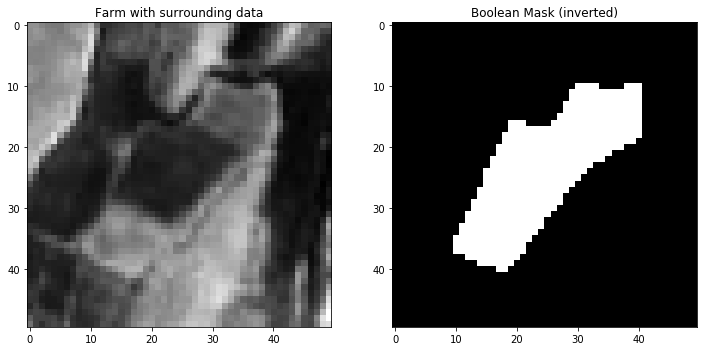

In [15]:
MAX_DIMS = (50, 50)

pad_x = int(np.ceil((MAX_DIMS[0]-bb_shape[0])/2))
pad_y = int(np.ceil((MAX_DIMS[1]-bb_shape[1])/2))

# Get a window with padding around it and the desired shape in the center
padded_window = rasterio.mask.geometry_window(raster, 
                                              [shape], 
                                              pad_x=pad_x, 
                                              pad_y=pad_y, 
                                              pixel_precision=2)

print('Padded window shape = ', padded_window.height, padded_window.width)

print('Pad x = ',pad_x, '\nPax y = ',pad_y)

padded_img = raster.read(window=padded_window)[0]

padded_img = padded_img[:MAX_DIMS[0], :MAX_DIMS[1]]

print('Padded image shape = ',padded_img.shape)

data = np.zeros((2, *MAX_DIMS))

data[:-1, :, :] = padded_img

# Add the mask to the last channel
data[-1, pad_y:-pad_y+1, pad_x:-pad_x+1] = int_mask

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 12))
ax0.imshow(data[0], cmap='gray')
ax0.set_title('Farm with surrounding data')
ax1.imshow(data[-1], cmap='gray')
ax1.set_title("Boolean Mask (inverted)")
plt.show()

raster.close()

## Put padded masking in a method

In [68]:
def get_mask_window(shape, raster, max_dims=None):
    
    # Get the boolean mask and window of shape
    try:
        bool_mask, transform, bb_window = rasterio.mask.raster_geometry_mask(raster, [shape], crop=True)
    except ValueError:
        print('Farm not found')
        return None
    
    if max_dims is  None:
        return bb_window
    else:

        # Turn mask into int array with 1 at farm pixels
        int_mask = np.bitwise_not(bool_mask).astype(int)

        # Get the shape of the bounding box window
        bb_shape = (bb_window.height, bb_window.width)


        # Get number of pixels to add to x and y dims
        pad_x = int(np.ceil((max_dims[1]-bb_shape[1])/2))
        pad_y = int(np.ceil((max_dims[0]-bb_shape[0])/2))

        # Get a window with padding around it and the desired shape in the center
        # Depending on the shape, this window can be a different size than max_dims
        window_ = rasterio.mask.geometry_window(raster, 
                                                      [shape], 
                                                      pad_x=pad_x, 
                                                      pad_y=pad_y, 
                                                      pixel_precision=2 # I found this fixes some rounding errors
                                                     )

        # To fix sizing issues, create a new window that starts at the same top left anchor, but of a fixed width and height
        window = rasterio.windows.Window(col_off=window_.col_off, row_off=window_.row_off, width=max_dims[1], height=max_dims[0])
    
        return window
    
    



def read_window(raster, window, band=0):
    
    return raster.read(window=window)[band]

def get_mask_padded(shape, raster, max_dims):
    
    padded_window = get_mask_window(shape, raster, max_dims)
    
    # Read the padded image data
    padded_img = read_window(raster, window, band=0)
    
    # Clip the data to be in the range of max dims
    padded_img = padded_img[:max_dims[0], :max_dims[1]]
    
    assert padded_img.shape == max_dims, 'Padded image was not the right shape. Something went wrong :L'

    # Create 2-channel array with image data in first channel and mask in last channel
    data = np.zeros((2, *max_dims))
    data[:-1, :, :] = padded_img
    data[-1, pad_y:-pad_y+1, pad_x:-pad_x+1] = int_mask
    
    return data

### Test it

Farm shape:


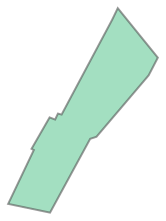

In [131]:
fp = os.path.join(img_dir,'B04_JFP.jp2')

raster = rasterio.open(fp)

out_shape = (50,50)

farm_shapes = train_df.geometry.to_list()

# Get an boolean mask array with all farms in it
masked_raster, _, _  = rasterio.mask.raster_geometry_mask(raster, farm_shapes, invert=True)

farm_shape = train_df.geometry.iloc[3]

print('Farm shape:')
display(farm_shape)

# The window defining where on the raster this shape is found
mask_window = get_mask_window(farm_shape, raster, max_dims=None)

# The same window, but padded to the desired dims
mask_window_padded = get_mask_window(farm_shape, raster, max_dims=out_shape)

# Crop out the image data around the shape 
win_img = raster.read(window=mask_window_padded)[0]

# Crop out the boolean mask of all farms in the window around the farm of interest
win_mask_other = masked_raster[mask_window_padded.row_off:mask_window_padded.row_off+MAX_DIMS[0], mask_window_padded.col_off:mask_window_padded.col_off+MAX_DIMS[1]]

temp = np.copy(masked_raster)

temp[:mask_window.row_off,:] = False
temp[mask_window.row_off+mask_window.width:,:]=False
temp[:,:mask_window.col_off] = False
temp[:,mask_window.col_off+mask_window.height:]=False

win_mask_farm = temp[mask_window_padded.row_off:mask_window_padded.row_off+MAX_DIMS[0], mask_window_padded.col_off:mask_window_padded.col_off+MAX_DIMS[1]]

del temp


data = np.zeros((3, *out_shape))

data[0] = win_img
data[1] = win_mask_other
data[2] = win_mask_farm

raster.close()

Text(0.5, 1.0, 'Mask This Farm')

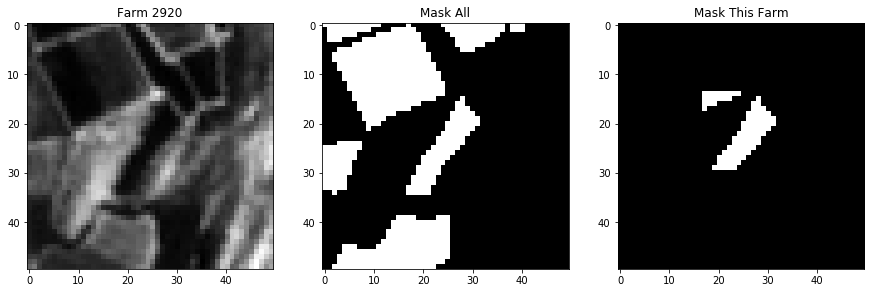

In [132]:
fig, axes = plt.subplots(1, 3, figsize=(15,15))

ax=axes[0]
ax.imshow(data[0], cmap='gray')
ax.set_title('Farm {}'.format(random_farm_id))

ax=axes[1]
ax.imshow(data[1], cmap='gray')
ax.set_title('Mask All')

ax=axes[2]
ax.imshow(data[2], cmap='gray')
ax.set_title('Mask This Farm')

### Another Approach

1. Create mask array for all farms on the entire raster
 - ie create a boolean mask array of the same shape of the raster which is 1 where farms are present in pixels.
2. Get window of desired shape containing farm shape and surrounding data
3. Read image data of window
4. Read mask data of window
5. Combine image and mask data into one array with multiple channels

In [ ]:
from tqdm import tqdm

def get_farm_data(masked_raster, raster, farm_shape, out_shape):
    
    this_farm_masked_raster = rasterio.mask.raster_geometry_mask(raster, [farm_shape], invert=True)
    
    # The window defining where on the raster this shape is found
    mask_window = get_mask_window(farm_shape, raster, max_dims=None)
    
    # The same window, but padded to the desired dims
    mask_window_padded = get_mask_window(farm_shape, raster, max_dims=out_shape)

    # Crop out the image data around the shape 
    win_img = raster.read(window=mask_window)[0]
    
    win_mask_farm = masked_raster[]

    # Crop out the boolean mask of all farms in the window around the farm of interest
    win_mask_other = masked_raster[mask_window_padded.row_off:mask_window_padded.row_off+MAX_DIMS[0], mask_window_padded.col_off:mask_window_padded.col_off+MAX_DIMS[1]]
    
    

    data = np.zeros((3, *out_shape))

    data[0] = win_img
    data[1] = win_mask_other
    data[-1] = win_mask_farm
    
    return data


def get_farms_data(farm_shapes, raster, out_shape):
    """
    
    """
    
     # Get an boolean mask array with all farms in it
    masked_raster, _, _  = rasterio.mask.raster_geometry_mask(raster, farm_shapes.geometry.to_list(), invert=True)
    
    all_data = {}
    
    for id, shape in tqdm(farm_shapes.iteritems()):
        all_data[id] = get_farm_data(masked_raster, raster, shape, out_shape)
        
    return all_data
        

In [74]:
MAX_DIMS = (80, 80)

fp = os.path.join(img_dir,'B04_JFP.jp2')

farm_shapes = train_df.set_index("Field_Id").geometry

# Pick a shape to prototype with
shape = farm_shapes.iloc[0]

with rasterio.open(fp) as raster:
    
    farms_data = get_farms_data(farm_shapes, raster, MAX_DIMS)


0it [00:00, ?it/s]
1it [00:00,  4.62it/s]
2it [00:00,  5.21it/s]
3it [00:00,  5.72it/s]
4it [00:00,  6.13it/s]
5it [00:00,  6.49it/s]
6it [00:00,  6.73it/s]
7it [00:01,  6.91it/s]
8it [00:01,  7.06it/s]
9it [00:01,  7.05it/s]
10it [00:01,  7.08it/s]
11it [00:01,  7.05it/s]
12it [00:01,  7.02it/s]
13it [00:01,  7.00it/s]
14it [00:02,  6.99it/s]

KeyboardInterrupt: 

### Show image and mask data of 3 random farms

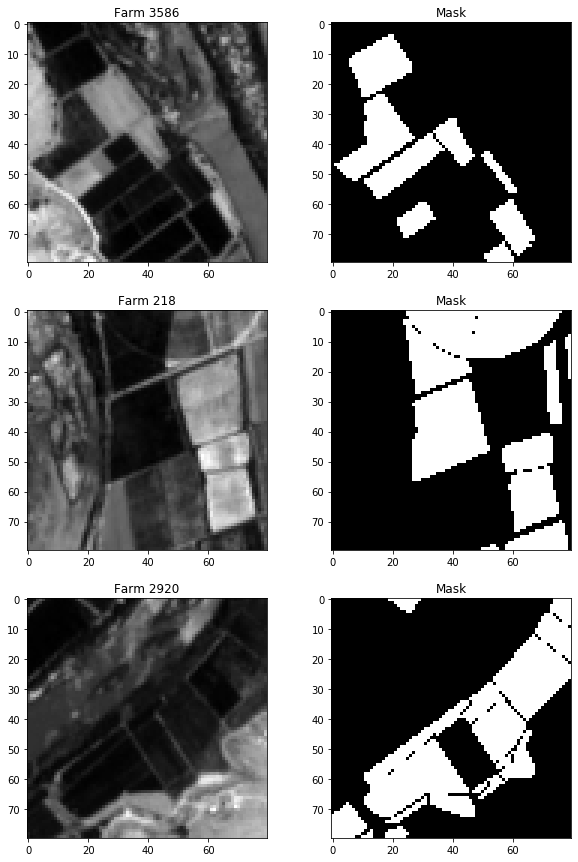

In [65]:
fig, axes = plt.subplots(3, 2, figsize=(10,15))

choices = np.random.choice(list(farms_data.keys()), (3,))


for i, random_farm_id in enumerate(choices):
    farm_data = farms_data[random_farm_id]

    ax=axes[i][0]
    ax.imshow(farm_data[0], cmap='gray')
    ax.set_title('Farm {}'.format(random_farm_id))

    ax=axes[i][1]
    ax.imshow(farm_data[1], cmap='gray')
    ax.set_title('Mask')

plt.show()